# Data Programming Approach for annotation and classification of TRUE ADRs

In [1]:
import pandas as pd
import pickle
import sys
sys.path.append('/Users/jarvis/Desktop/CODE/sadrat/')

from scrapers.helpers import Preprocessing

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
stop_list = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [3]:
df = pd.read_csv("/Users/jarvis/Desktop/CODE/sadrat/sample/medications_dot_com_data.csv")

In [4]:
df.head()

,id,drugname,comment
0,0,levaquin,ive been allergic to many antibiotics since I ...
1,1,levaquin,Was prescribed leviquin for sinus. Took dose ...
2,2,levaquin,Been reading the blog - thank God. Thank God ...
3,3,levaquin,1/14/2012. I was given Levaquin and two steroi...
4,4,levaquin,today was my 3rd day of taking levaquin. i suf...


In [5]:
#looking at the comments to have an intuition for labelling functions
#PLEASE NOTE THAT I MADE A SILLY MISTAKE WHILE NAMING MY COLUMN IN THE DATASET, THERE'S A SPACE BEFORE 
# "comment" AND "drugname". WRITE IT AS " comment" and " drugname". 
df[" comment"][13]

"Dee1967 I was been placed on Lisinopril 20mg's daily.Since then i have had severe body pains,weakness in arm's leg's,vision impairment,hairloss,cough,sore throat severe dry mouth,blistering on the back of my tongue.It is so bad i cannot lift my arm's or\xa0... more »Dee1967 I was been placed on Lisinopril 20mg's daily.Since then i have had severe body pains,weakness in arm's leg's,vision impairment,hairloss,cough,sore throat severe dry mouth,blistering on the back of my tongue.It is so bad i cannot lift my arm's or walk some day's.My vision is so bad at time's i cannot even read a simple sentence.And the dizziness is severe.Nauseated constantly and weigh gain.This drug is dangerous! I have taken myself off of this drug,but the side effect's are severe and have not subsided.Their were some day's my throat felt so enlarged i could not swallow,it is and was a very tramatic experience.To lift a pillow at time's was a job.The pain and numbness esp at night scared me."

### Getting the dictionary of drugs and their known side effects scraped from drugs.com website.

In [6]:
with open("/Users/jarvis/Desktop/CODE/sadrat/datasets/drug_adr", "rb") as file:
    drugs = pickle.load(file)
file.close()

# Labelling Functions

In [7]:
# defining constants for clarity
ADR = 1
ABSTAIN = -1
NOADR = 0

In [8]:
from snorkel.labeling import labeling_function

## LF1: Sentiment Analysis
The ADRs are usually written with a negative tone so starting with sentiment analysis as the first labelling function is a good start : )

In [9]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob

In [10]:
import matplotlib.pyplot as plt

In [11]:
@preprocessor(memoize=True)
# type(x) - pandas Series
def textblob_sentiment(x):
    scores = TextBlob(x[" comment"])
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [12]:
comment_polarities = [textblob_sentiment(x).polarity for _, x in df.iterrows()]
comment_subjectivities = [textblob_sentiment(x).subjectivity for _, x in df.iterrows()]

#### NOTE:
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. <br>
**Hence a probable ADR must have low polarity and high subjectivity**

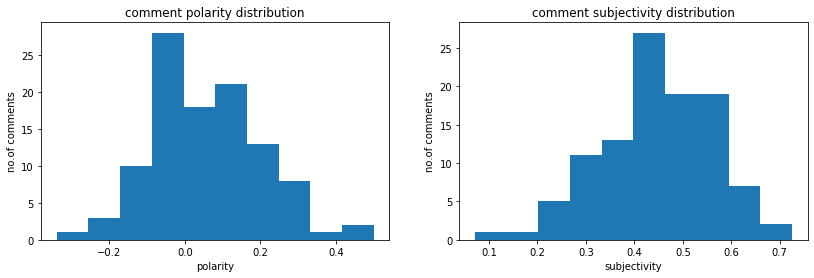

In [13]:
# plotting the data
plt.subplot(1,2,1)
plt.hist(comment_polarities, bins=10)
plt.title("comment polarity distribution")
plt.xlabel("polarity")
plt.ylabel("no.of comments")
plt.subplots_adjust(hspace=1, left=0.225, right=2, wspace=0.2)

plt.subplot(1,2,2)
plt.hist(comment_subjectivities, bins=10)
plt.title("comment subjectivity distribution")
plt.xlabel("subjectivity")
plt.ylabel("no.of comments")
plt.savefig("sentiment_analysis2.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()


In [14]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return ADR if x.polarity < 0 else ABSTAIN

In [15]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return ADR if x.subjectivity > 0.6 else ABSTAIN

# LF2: Based on Known ADRs - Distant Supervision
Return 1 if ADR for the given drug is already known else return 0.<br>
Use the preprocessing function from helpers.py

### \# Semantic Similarity (used by LF2)
Finding the semantic similarity between the user comment and all the known adr for the particular drug

In [1]:
def semantic_similarity(comment):
    """
    @params: 
            type(comment): string
            
    credits: geeksforgeeks.org for some part of the below code
    https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/
    """
    p = Preprocessing()
    extracted_drugs_list = list()
    known_adr = ""
    clean_comment = p.simple_preprocessor_string(comment)
    for word in clean_comment.split():
        if word.capitalize() in drugs.keys():
            extracted_drugs_list.append(word)
            for adr in drugs[word.capitalize()]:
                known_adr = known_adr + adr
        else:
            continue
#     print(known_adr)
    # clean the adr sentence
    known_adr = re.sub('[,-]','',known_adr)
    
    ### calculate cosine similarity between known_adr and clean_comment
    l1 = list()
    l2 = list()
    #tokenize the strings
    clean_comment_set = {x for x in word_tokenize(clean_comment)}
    known_adr_set = {x for x in word_tokenize(known_adr)}
    
    #form a set containing keywords of both strings
    rvec = clean_comment_set.union(known_adr_set)
    
    for w in rvec:
        if w in clean_comment_set:
            l1.append(1)
        else:
            l1.append(0)
        if w in known_adr_set:
            l2.append(1)
        else:
            l2.append(0)
    c = 0
    
    # cosine formula
    for i in range(len(rvec)):
        c = c + l1[i]*l2[i]
        
    if (sum(l1) and sum(l2)) != 0:
        cosine_similarity_score = c/float(sum(l1)*sum(l2)**0.5)
        return cosine_similarity_score
    else:
        return 0

In [17]:
# test semantic_similarity
print(semantic_similarity("Dee1967 I was been placed on Lisinopril 20mg's daily.Since then i have had severe body pains,weakness in arm's leg's,vision impairment,hairloss,cough,sore throat severe dry mouth,blistering on the back of my tongue.It is so bad i cannot lift my arm's or\xa0... more »Dee1967 I was been placed on Lisinopril 20mg's daily.Since then i have had severe body pains,weakness in arm's leg's,vision impairment,hairloss,cough,sore throat severe dry mouth,blistering on the back of my tongue.It is so bad i cannot lift my arm's or walk some day's.My vision is so bad at time's i cannot even read a simple sentence.And the dizziness is severe.Nauseated constantly and weigh gain.This drug is dangerous! I have taken myself off of this drug,but the side effect's are severe and have not subsided.Their were some day's my throat felt so enlarged i could not swallow,it is and was a very tramatic experience.To lift a pillow at time's was a job.The pain and numbness esp at night scared me."))

0.007190916418846245


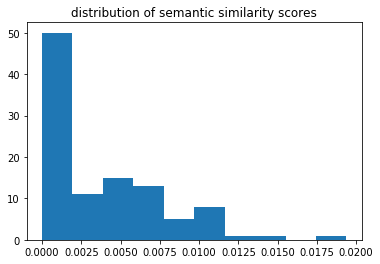

In [18]:
# plot semantic similarity over all datapoints
Y = list()
P = list()
for _, x in df.iterrows():
    Y.append(semantic_similarity(x[" comment"]))
    
plt.title("distribution of semantic similarity scores")
plt.hist(Y, bins = 10)
plt.savefig("sentiment_analysis2.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

In [19]:
@labeling_function()
def distant_supervision(x):
    """
    @params: type(x) - pandas series object
    """
    if semantic_similarity(x[" comment"]) == 0:
        return ABSTAIN
    else:
        return ADR

In [20]:
### DEPRECATED
### @labeling_function()
### DEPRECATED: WE ARE NOT USING THIS FUNCTION ANYMORE
def distant_supervision_deprecated(x):
    """
    @params: type(x): str
    return 1 if ADR is a known ADR and 0 if not known ADR
    """
    extracted_drugs_list = list()
    known_adr_list = list()
    # Preprocess the string
    p = Preprocessing()
    clean_text = p.simple_preprocessor_string(x)
    clean_text = word_tokenize(clean_text)
    for word in clean_text:
        if word.capitalize() in drugs.keys():
            extracted_drugs_list.append(word.capitalize())
            known_adr_list.append(drugs[word.capitalize()])
        else:
            continue
    if len(extracted_drugs_list) != 0:
        phrases = list()
        clean_phrase = ""
        # make a single sentence with lemmatization
        for i in range(len(known_adr_list)):
            for phrase in known_adr_list[i]:
                # tokenize, remove stop words and lemmatize
                word_tokens = word_tokenize(phrase)
                filtered_phrase = [word for word in word_tokens if not word in stop_list]
                for word in filtered_phrase:
                    clean_phrase = clean_phrase + stemmer.stem(word) + " "
                phrases.append(clean_phrase)
    else:
        return -1
    
    clean_sentence = ""
    for clean_word in clean_text:
        clean_sentence = clean_sentence + stemmer.stem(clean_word) + " "
    
    print(clean_sentence)
    print(phrases)
    matched_phrases = phrase_matcher_ADR(clean_sentence, phrases)
    print(matched_phrases)
#     print(known_adr_list)
#     print(extracted_drugs_list)

## LF3: Clustering with TF.IDF Vectorization and KNN 
In this LF(LF3), We implement non-hierarchial clustering with two or three clusters, we then have to use another LF(say LF2) to determine the cluster that has higher number of positive ADRs and the one with the lower/lowest number of positive ADRs.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [5]:
df = pd.read_csv("/Users/jarvis/Desktop/CODE/sadrat/sample/medications_dot_com_data.csv")

In [6]:
def clustering(x):
    """
    @params: type(x): list of raw documents(list of strings)
    """
    if len(x) == 0:
        raise Exception("Size of input list should be greater than 0")
    
    K = 3  # value of K in KNN
    
    # Preprocess documents(document is just another way of saying a sentence)
    p = Preprocessing()
    clean_corpus = list()
    for doc in x:
        if(type(doc) != str):
            raise Exception("The input list must contain string datatype")
        clean_doc = p.simple_preprocessor_string(doc)
        
        #case when after preprocessing nothing remains in the string (useless document)
        if clean_doc == "":
            continue
        else:
            clean_corpus.append(clean_doc)
        
#     print(clean_corpus[1], type(clean_corpus[1]))
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(clean_corpus)
    model = KMeans(n_clusters=K, init='k-means++')
    model.fit(X)
    
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(K):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(terms[ind], end=" ")
        print("\n")


In [7]:
# Driver Code
raw_corpus = list()
for _, x in df.iterrows():
    raw_corpus.append(x[" comment"])
clustering(raw_corpus)

Top terms per cluster:
Cluster 0:
pressure cozaar blood high six pain years last side moncler 

Cluster 1:
cipro pain day infection side effects hurts feeling prescribed levaquin 

Cluster 2:
days mg day taking started like took get take time 



In [19]:
# Use the KNN model as labelling Function
# TODO:
# 1. Identify which cluster represents an ADR better (Requires another LF)
# 2. Return -1, 0 or 1 according to the model output


### LF 4: Look out for any mention of known ADR in the user comment

1. Make the Keyword space from the drug dictionary
2. Preprocess the user comment 
3. Use semantic similarity

In [23]:
# 1. Create Keywordspace
keywordspace = list()
for x in drugs.keys():
    for p in drugs[x]:
        for word in p.split():
            if word != "," and len(word) > 4 and word not in keywordspace:
                keywordspace.append(word)
                

In [24]:
def adr_term_matching(comment):
    """
    type(x): string
    """
    # preprocess x[" comment"]
    p = Preprocessing()
    clean_text = p.simple_preprocessor_string(comment)
    
    word_matches = 0
    for word in clean_text.split():
        if word in keywordspace:
            word_matches = word_matches + 1
        else:
            continue
    if word_matches != None:
        return word_matches
    else:
        return 0

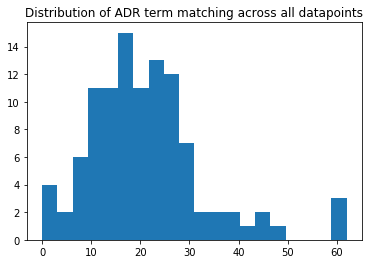

In [25]:
# plot distribution of adr word matches

X = list()
for _, x in df.iterrows():
    X.append(adr_term_matching(x[" comment"]))
plt.title("Distribution of ADR term matching across all datapoints")
plt.hist(X, bins = 20)
plt.show()

#### Asumption: 
Take matching score above below 10 as NOADR 10 to 20 as ABSTAIN and above 20 as ADR<br>
`again, this is just a guess and you can play with these thresholds to get a better labeling function`

In [26]:
@labeling_function()
def simple_term_matching(x):
    """
    type(x): pandas Series object
    """
    score = adr_term_matching(x[" comment"])
    if score != None:
        if score <= 10 :
            return NOADR
        elif score > 10 and score < 20:
            return ABSTAIN
        elif score > 20:
            return ADR
    else:
        return ABSTAIN
    
    return ABSTAIN

## Apply LFs

#### Creating a test set and a training set
create a test set by manualy labelling the ADRs.

In [29]:
df_test = df.sample(10, random_state=3)
df_test["label"] = [1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
df_test.head()

,id,drugname,comment,label
15,1,avelox,I have a chronic bacterial infection for which...,1
34,4,cipro,i was given cipro for kidney stones. i took it...,1
58,2,aricept,My father has only been on aricept for a short...,1
103,4,warfarin-sodium,The 1960 study of anti-coagulants for pulmonar...,0
5,5,levaquin,today was my 3rd day of taking levaquin. i suf...,1


In [58]:
# make the training set
drop_index_list = list(df_test.index)
df_train = df.drop(drop_index_list)
df_train.shape

(95, 3)

In [59]:
from snorkel.labeling import PandasLFApplier
lfs = [textblob_polarity,
       textblob_subjectivity,
       distant_supervision,
       simple_term_matching
      ]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

/Users/jarvis/venvs/sadrat/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 95/95 [00:00<00:00, 127.41it/s]


### Evaluate Performance of LFs
#### 1. Coverage Check

In [60]:
coverage_textblob_polarity, coverage_textblob_subjectivity, coverage_distant_supervision,\
coverage_simple_term_matching = (L_train != ABSTAIN).mean(axis=0)
print(f"textblob_polarity coverage: {coverage_textblob_polarity * 100:.1f}%")
print(f"textblob_subjectivity coverage: {coverage_textblob_subjectivity * 100:.1f}%")
print(f"distant_supervision coverage: {coverage_distant_supervision * 100:.1f}%")
print(f"simple_term_matching coverage: {coverage_simple_term_matching * 100:.1f}%")

textblob_polarity coverage: 40.0%
textblob_subjectivity coverage: 6.3%
distant_supervision coverage: 53.7%
simple_term_matching coverage: 58.9%


#### Statistical Analysis of LFs

In [61]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[1],0.400000,0.368421,0.021053
textblob_subjectivity,1,[1],0.063158,0.063158,0.021053
distant_supervision,2,[1],0.536842,0.389474,0.021053
simple_term_matching,3,"[0, 1]",0.589474,0.452632,0.052632


In [62]:
L_dev = applier.apply(df=df_test)

/Users/jarvis/venvs/sadrat/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 10/10 [00:00<00:00, 125.91it/s]


#### Checking Empirical Accuracy of different LFs

In [63]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_test.label.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
textblob_polarity,0,[1],0.4,0.4,0.1,2,2,0.500000
textblob_subjectivity,1,[1],0.1,0.1,0.0,1,0,1.000000
distant_supervision,2,[1],0.7,0.5,0.1,6,1,0.857143
simple_term_matching,3,"[0, 1]",0.8,0.8,0.2,6,2,0.750000


We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another. We can view a histogram of how many LF labels the data points in our dev set have to get an idea of our total coverage.

In [33]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")

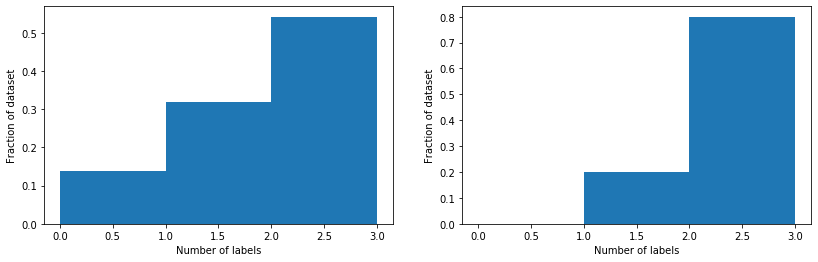

In [64]:
plt.subplot(1,2,1)
plot_label_frequency(L_train)
plt.subplots_adjust(hspace=1, left=0.225, right=2, wspace=0.2)
plt.subplot(1,2,2)
plot_label_frequency(L_dev)
plt.show()

More than 50% of the training dataset is labelled by 2-3 LFs and more than 70% of the test set is labelled by 2-3 LFs.<br>
Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted ADR than NOADR, label it ADR (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.MajorityLabelVoter.html#snorkel.labeling.MajorityLabelVoter).

In [65]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [66]:
preds_train

array([ 1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  0,  0, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  0,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1, -1,  0,  1,
        1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,
        1, -1,  1,  1,  0, -1, -1,  0,  1,  1, -1,  1,  1,  0,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1, -1,  1,  0])

However, as we can clearly see by looking the summary statistics of our LFs, they are not all equally accurate, and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelModel.html#snorkel.labeling.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.
The `LabelModel` trains much more quickly than typical discriminative models since we only need the label matrix as input.

In [67]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

In [68]:
majority_acc = majority_model.score(L=L_dev, Y=df_test.label.values)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_dev, Y=df_test.label.values)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   75.0%
Label Model Accuracy:     70.0%


Let's briefly confirm that the labels the `LabelModel` produces are probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

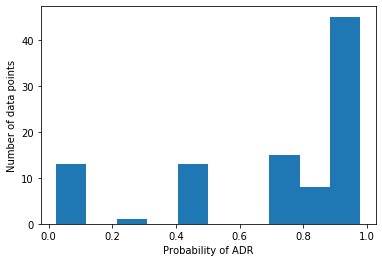

In [89]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of ADR")
    plt.ylabel("Number of data points")
    plt.savefig("prob_adr.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, ADR])

### Filtering out unlabeled data points
As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [71]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## Training a Classifier

Now we'll use the noisy training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost etc.**
In this tutorial, we demonstrate using classifiers from [Keras](https://keras.io) and [Scikit-Learn](https://scikit-learn.org).


### Featurization

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
X_train = vectorizer.fit_transform(df_train_filtered[" comment"].tolist())
X_test = vectorizer.transform(df_test[" comment"].tolist())

### Scikit-Learn with Rounded Labels

If we want to use a library or model that doesn't accept probabilistic labels, we can replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
It's important to note that this transformation is lossy, as we no longer have values for our confidence in each label.

In [73]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

This allows us to use standard models of scikit-learn

In [74]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=0.001, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
Y_test = df_test["label"].values
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 70.0%


In [4]:
if(print("k") or print("bye")):
    print("hello")
else:
    print("hey")

k
bye
hey
